In [1]:
# First import a bunch of useful stuff

import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from plotter import *

In [2]:
# This gives the integrated luminosity (the amount of data collected) for each year
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

In [3]:
# This dictionary gives the cross section (expected rate) of each simulated process
# Number of events of process P = integrated luminosity * cross section of process P
with open('xsec.json') as f:
  xs = json.load(f)
print(xs)

{'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 32200, 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 6839, 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 1207, 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 120.1, 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 25.24, 'QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8': 20.23, 'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madg

In [4]:
# This dictionary tells us how to group the simulated samples together sensibly
# For example, QCD is generated separately for different energies. Combine them
with open('pmap_mc.json') as f:
  pmap = json.load(f)
print(pmap)

{'ZH': ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8,'], 'WH': ['WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8'], 'ttH': ['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'], 'VBF': ['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'], 'ggF': ['GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8'], 'ggF-powheg': ['GluGluHToBB_M125_TuneCP5_13TeV-powheg-pythia8', 'GluGluHToBB_M125_13TeV_powheg_pythia8'], 'QCD': ['QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1500to2000_TuneC

In [5]:
# I like to run this for one year at a time
year = '2017'
outsum = processor.dict_accumulator()

year_2 = '2017'
outsum_2 = processor.dict_accumulator()

In [6]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [7]:
# Number-counting significance as a function of the number of signal (s) and background (b) events
def significance(s,b,q, cutq=False):
    if cutq and q<20:
        return 0
    if b<1:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [8]:
# The quickest option here: copy the pickle file from my area:
# /uscms/home/jennetd/nobackup/hbb-prod-modes/march-2021/vbf-ddbopt/pickles/templates.pkl

# To save time, I run the "load all files" step below once and pickle templates
# Then read in one histogram instead of loading all files each time
# First time I run with repickle=True. Else run with repickle=False
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/templates.pkl'
if os.path.isfile(picklename):
    repickle=False
    
repickle_2=True

# Check if pickle exists, and don't re-create it if it does
picklename_2 = 'pickles/templates_2.pkl'
if os.path.isfile(picklename_2):
    repickle_2=False

In [9]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        # Skip data - we are dealing with only simulation right now
        if 'JetHT' in infiles.keys():
            continue
        if 'SingleMuon' in infiles.keys():
            continue
    
        filename = '/myeosdir/vbf-ddbopt/outfiles/'+year+'_'+str(n)+'.coffea'
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates1'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()
    
    
if repickle_2:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        # Skip data - we are dealing with only simulation right now
        if 'JetHT' in infiles.keys():
            continue
        if 'SingleMuon' in infiles.keys():
            continue
    
        #filename_2 = 'vbf-ddbopt/outfiles-ddb2/'+year+'_'+str(n)+'.coffea'
        filename_2 = 'outfiles-ddb2/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename_2):
            out = util.load(filename_2)
            outsum_2.add(out)
        else:
            print("File " + filename_2 + " is missing")
        
    scale_lumi_2 = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum_2['sumw'].items()}
    outsum_2['templates-vbf'].scale(scale_lumi_2, 'dataset')
    
    # Use pmap to group the datasets together
    templates_2 = outsum_2['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates_2 = templates_2.integrate('region', 'signal')

    outfile_2 = open(picklename_2, 'wb')
    pickle.dump(templates_2, outfile_2, protocol=-1)
    outfile_2.close()

In [10]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))

# Sum over all bins and print the total number of events per process
templates.sum('msd1','deta','mjj','ddb1').values()

{('ZH',): 14.499776537922521,
 ('WH',): 11.532616177845286,
 ('ttH',): 21.93820561446167,
 ('VBF',): 32.657991137640366,
 ('ggF',): 76.851075716208,
 ('ggF-powheg',): 156.59744103535937,
 ('QCD',): 4008994.443499559,
 ('VV',): 1288.3117120342106,
 ('Wjets',): 91422.54090350348,
 ('Zjets',): 43273.63568807628,
 ('ttbar',): 19757.769359435322,
 ('singlet',): 3109.7628093855697}

In [11]:
templates_2 = pickle.load(open(picklename_2,'rb'))

templates_2.sum('msd1','deta','mjj','ddb1').integrate('systematic', 'nominal').values()

{('ZH',): array(14.30482859),
 ('WH',): array(11.41398191),
 ('ttH',): array(21.68612532),
 ('VBF',): array(32.28007896),
 ('ggF',): array(75.87214395),
 ('ggF-powheg',): array(154.90639948),
 ('QCD',): array(3956029.49910738),
 ('VV',): array(1273.53049952),
 ('Wjets',): array(87111.29949286),
 ('Zjets',): array(37622.62585502),
 ('ttbar',): array(19498.99464288),
 ('singlet',): array(3073.46512155)}

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=deta) instance at 0x7f24ff022400>: requested start 3.78 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f24ff022490>: requested start 1280 between bin boundaries, no interpolation is performed
  warnings.warn(


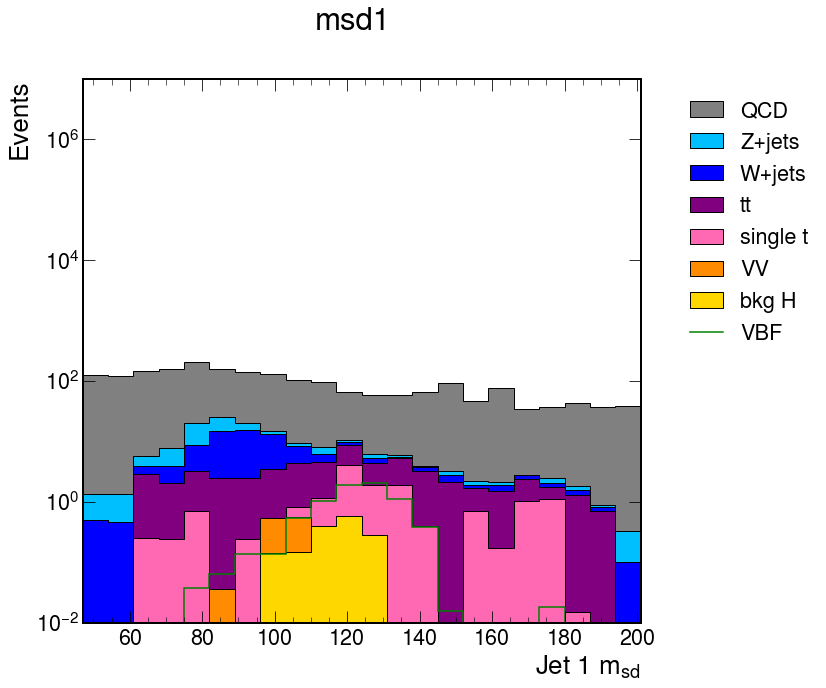

In [12]:
# Select out events in the Higgs mass window
templates_window=templates.integrate('msd1',int_range=slice(mbb_min,mbb_max))

#cut to optimal significance
all_optim = templates.integrate('deta',int_range=slice(3.78,7)).integrate('mjj',int_range=slice(1280,4000)).integrate('ddb1',int_range=slice(0.87,1))

# draw the plot of soft drop mass

# NB: the Higgs mass window is 110-138 GeV
plot_mconly_vbf(all_optim,'msd1','msd1')

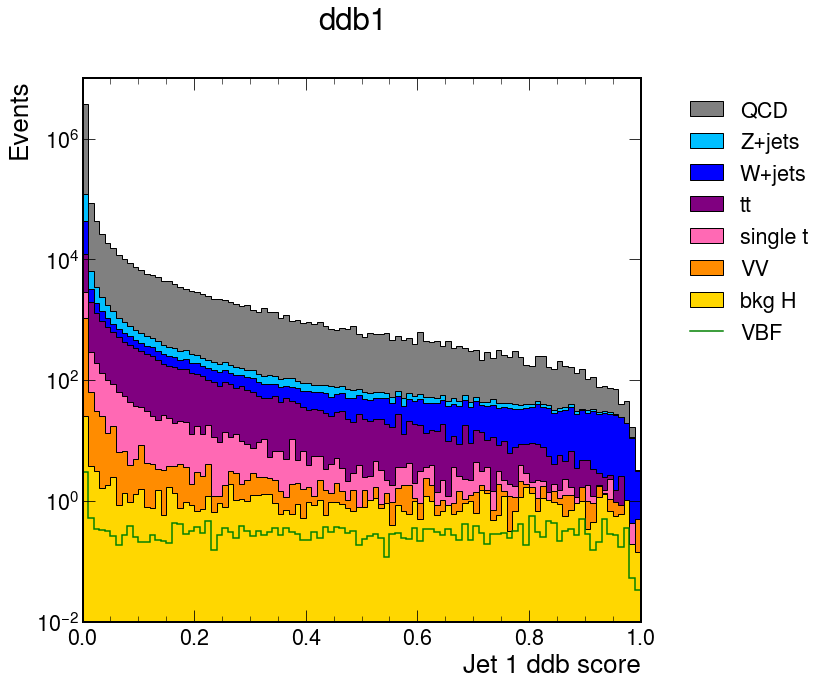

In [13]:
#cut v2 optimally, plot by soft drop mass
all_optim2 = templates_2.integrate('systematic', 'nominal').integrate('deta',int_range=slice(0,7)).integrate('mjj',int_range=slice(0,4000)).integrate('msd1',int_range=slice(47, 201))
plot_mconly_vbf(all_optim2,'ddb1','ddb1')

In [14]:
ddbs = [x.lo for x in all_optim2.identifiers('ddb1')]
plot_thing = {}
for x in ddbs:
    res = all_optim2.integrate('ddb1', int_range=slice(x, 1)).values()
    for y in res:
        if y not in plot_thing:
            plot_thing[y] = res[y]
        else:
            g=2
            
    print(res.values())

dict_values([14.304828589832868, 11.4139819129795, 21.686125320483697, 32.28007896249089, 75.87214395099782, 154.90639948240496, 3956029.4991073757, 1273.5304995197805, 87111.29949285633, 37622.625855015205, 19498.994642876267, 3073.465121554772])
dict_values([8.839498985087143, 6.169026660116292, 14.260506031242137, 29.24996186121104, 68.41451313915016, 141.4829373448717, 299977.0941235869, 240.2508955401336, 10765.016871840291, 6669.7739293988125, 9962.783571876522, 1262.5749134165426])
dict_values([8.367493855624435, 5.655436003612417, 12.7243442235202, 28.732535053077193, 67.18113858597619, 137.85918786373685, 220918.84236568984, 180.97175931334118, 7497.335088740741, 5487.211152115962, 8257.207078063042, 1034.6137377623704])
dict_values([8.089574135366135, 5.3363980374543525, 11.65674764868077, 28.39499439163786, 65.69859359471477, 136.5035150857213, 181555.7277188131, 152.6317521843973, 5935.3244804515125, 4868.420211050535, 7148.768822669555, 872.5270321186847])
dict_values([7.8

AssertionError: 66 66.000000 <Bin (name=ddb1) instance at 0x7f24f9789130>

In [ ]:
templates_2.identifiers('msd1')

In [ ]:
#cut v2 optimally, plot by soft drop mass
all_optim2 = templates_2.integrate('systematic', 'nominal').integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000)).integrate('ddb1',int_range=slice(0.64,1))
plot_mconly_vbf(all_optim2,'msd1','msd1')

In [ ]:
templates_window2 = templates_2.integrate('systematic', 'nominal').integrate('msd1', int_range=slice(110,138)) 

In [ ]:
# Apply a cut
templates_cut = templates_window.integrate('deta',int_range=slice(3,7)).integrate('mjj',int_range=slice(1500,4000))

# Print the number of events passing the cut per process
templates_cut.sum('ddb1').values()

In [ ]:
sr = templates_cut.integrate('ddb1',int_range=slice(0.87,1)).values()

# Get the number of signal and background events
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]
q = sr[('QCD',)]

# Print the significance
print(significance(s,b, q))
# Note: this only makes sense in the mass window of Higgs

In [ ]:
sr

In [ ]:
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_1 = os.path.isfile('ddb1-scan.npy')
if not scan_1:
    mjj_edges = [x.lo for x in templates_window.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('VBF',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('ddb1-scan.npy', res2)

In [ ]:
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_2 = os.path.isfile('ddb2-scan.npy')
if not scan_2:
    mjj_edges = [x.lo for x in templates_window2.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window2.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window2.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window2.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('VBF',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('ddb2-scan.npy', res2)

In [ ]:
#load 3d scans for v1 and v2 of ddb
ddb1_scan = np.load('ddb1-scan.npy')
ddb2_scan = np.load('ddb2-scan.npy')

In [ ]:
mjj_edges2 = [x.lo for x in templates_window2.identifiers('mjj')]
deta_edges2 = [x.lo for x in templates_window2.identifiers('deta')]
dbb_edges2 = [x.lo for x in templates_window2.identifiers('ddb1')]
nmjj2 = len(mjj_edges)
ndeta2 = len(deta_edges)
ndbb2 = len(dbb_edges)

tempg = templates_window

mjj_edges = [x.lo for x in tempg.identifiers('mjj')]
deta_edges = [x.lo for x in tempg.identifiers('deta')]
dbb_edges = [x.lo for x in tempg.identifiers('ddb1')]
nmjj = len(mjj_edges)
ndeta = len(deta_edges)
ndbb = len(dbb_edges)

lx = ndeta
ly = nmjj
lz = ndbb

x2, y2, z2 = np.unravel_index(np.argmax(ddb1_scan), ddb1_scan.shape)

x3, y3, z3 = np.unravel_index(np.argmax(ddb2_scan), ddb2_scan.shape)


print('v1: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(ddb1_scan), mjj_edges[y2], deta_edges[x2], dbb_edges[z2]))
print('v2: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(ddb2_scan), mjj_edges2[y3], deta_edges2[x3], dbb_edges2[z3]))

In [ ]:
tempg = templates_window

mjj_edges = [x.lo for x in tempg.identifiers('mjj')]
deta_edges = [x.lo for x in tempg.identifiers('deta')]
ddb_edges = [x.lo for x in tempg.identifiers('ddb1')]
nmjj = len(mjj_edges)
ndeta = len(deta_edges)
ndbb = len(dbb_edges)

plt.figure()
plt.plot(ddb1_scan[x2,:,z2])
label = 'mjj'
dat = mjj_edges
ndat = len(dat)
ratlabels = 2

plt.title('Significance by %s, ddb=0.87, dEta=4'%label)
plt.xlabel('min cut for %s'%label)
plt.xticks(np.arange(round(ndat/ratlabels))*ratlabels, [round(dat[x], 2) for x in np.arange(round(ndat/ratlabels))*ratlabels])
plt.ylabel('Significance')
plt.savefig('%sv1.png'%label)

In [ ]:
tempg = templates_window2

mjj_edges = [x.lo for x in tempg.identifiers('mjj')]
deta_edges = [x.lo for x in tempg.identifiers('deta')]
dbb_edges = [x.lo for x in tempg.identifiers('ddb1')]
nmjj = len(mjj_edges)
ndeta = len(deta_edges)
ndbb = len(dbb_edges)


mjjdet2 = np.rot90(ddb2_scan[:, :, z3])
plt.figure()
plt.imshow(mjjdet2)
plt.title('Significance for mjj vs. dEta\n version 2 ddb1')
plt.colorbar()
plt.ylabel('min cut for mjj')
plt.xlabel('min cut for dEta')
mjj_edges.reverse()
plt.yticks(np.arange(nmjj), mjj_edges)
plt.xticks(np.arange(ndeta), deta_edges)
plt.tight_layout()
plt.savefig('mjjdetav2.png')

In [ ]:
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_z1 = os.path.isfile('zhv1-scan.npy')
if not scan_z1:
    mjj_edges = [x.lo for x in templates_window.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('ZH',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('VBF',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('zhv1-scan.npy', res2)
    
    
    
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_z2 = os.path.isfile('zhv2-scan.npy')
if not scan_z2:
    mjj_edges = [x.lo for x in templates_window2.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window2.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window2.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window2.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('ZH',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('VBF',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('zhv2-scan.npy', res2)
    
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_w1 = os.path.isfile('whv1-scan.npy')
if not scan_w1:
    mjj_edges = [x.lo for x in templates_window.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('WH',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('ZH',)] + sr[('VBF',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('whv1-scan.npy', res2)
    
    
    
#make 3d array of significance scan for mjj, deta, ddb2 only measured at bin edges (version 2)
scan_w2 = os.path.isfile('whv2-scan.npy')
if not scan_w2:
    mjj_edges = [x.lo for x in templates_window2.identifiers('mjj')]
    deta_edges = [x.lo for x in templates_window2.identifiers('deta')]
    dbb_edges = [x.lo for x in templates_window2.identifiers('ddb1')]
    nmjj = len(mjj_edges)
    ndeta = len(deta_edges)
    ndbb = len(dbb_edges)
    res2 = np.zeros((ndeta, nmjj, ndbb))
    #qs = np.zeros((ndeta, nmjj, ndbb))
    for x in tqdm(range(ndeta)):
        det = deta_edges[x]
        for y in range(nmjj):
            mj = mjj_edges[y]
            templates_cut = templates_window2.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(ndbb):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(dbb_edges[z],1)).values()

                    # Get the number of signal and background events
                    s = sr[('WH',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('ZH',)] + sr[('VBF',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q, cutq=True)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    #qs[x][y][z] = q
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('whv2-scan.npy', res2)

In [ ]:
#load 3d scans for v1 and v2 of ddb
zh1_scan = np.load('zhv1-scan.npy')
zh2_scan = np.load('zhv2-scan.npy')


mjj_edges2 = [x.lo for x in templates_window2.identifiers('mjj')]
deta_edges2 = [x.lo for x in templates_window2.identifiers('deta')]
dbb_edges2 = [x.lo for x in templates_window2.identifiers('ddb1')]
nmjj2 = len(mjj_edges)
ndeta2 = len(deta_edges)
ndbb2 = len(dbb_edges)

tempg = templates_window

mjj_edges = [x.lo for x in tempg.identifiers('mjj')]
deta_edges = [x.lo for x in tempg.identifiers('deta')]
dbb_edges = [x.lo for x in tempg.identifiers('ddb1')]
nmjj = len(mjj_edges)
ndeta = len(deta_edges)
ndbb = len(dbb_edges)

lx = ndeta
ly = nmjj
lz = ndbb

x2, y2, z2 = np.unravel_index(np.argmax(zh1_scan), zh1_scan.shape)

x3, y3, z3 = np.unravel_index(np.argmax(zh2_scan), zh2_scan.shape)


print('zh v1: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(zh1_scan), mjj_edges[y2], deta_edges[x2], dbb_edges[z2]))
print('zh v2: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(zh2_scan), mjj_edges2[y3], deta_edges2[x3], dbb_edges2[z3]))

In [ ]:
#load 3d scans for v1 and v2 of ddb
zh1_scan = np.load('whv1-scan.npy')
zh2_scan = np.load('whv2-scan.npy')

mjj_edges2 = [x.lo for x in templates_window2.identifiers('mjj')]
deta_edges2 = [x.lo for x in templates_window2.identifiers('deta')]
dbb_edges2 = [x.lo for x in templates_window2.identifiers('ddb1')]
nmjj2 = len(mjj_edges)
ndeta2 = len(deta_edges)
ndbb2 = len(dbb_edges)

tempg = templates_window

mjj_edges = [x.lo for x in tempg.identifiers('mjj')]
deta_edges = [x.lo for x in tempg.identifiers('deta')]
dbb_edges = [x.lo for x in tempg.identifiers('ddb1')]
nmjj = len(mjj_edges)
ndeta = len(deta_edges)
ndbb = len(dbb_edges)

lx = ndeta
ly = nmjj
lz = ndbb

x2, y2, z2 = np.unravel_index(np.argmax(zh1_scan), zh1_scan.shape)

x3, y3, z3 = np.unravel_index(np.argmax(zh2_scan), zh2_scan.shape)


print('wh v1: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(zh1_scan), mjj_edges[y2], deta_edges[x2], dbb_edges[z2]))
print('wh v2: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(zh2_scan), mjj_edges2[y3], deta_edges2[x3], dbb_edges2[z3]))

## Archive: 
Functions/code that I used to make plots I presented, but have since improved.

In [ ]:
#make 3d array of significance scan for mjj, deta, ddb1 (100 steps, not very efficient. better version below)
scan_1 = os.path.isfile('ddb1-scan100.npy')
if not False: #scan_1:
    detedges = templates_window.identifiers('deta')
    res = np.zeros((100, 100, 100))
    for x in tqdm(range(100)):
        det = x/100*7
        for y in range(100):
            mj = y*40
            templates_cut = templates_window.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(100):
                if not z == 34:
                    #34 always throws an error
                    try:
                        sr = templates_cut.integrate('ddb1',int_range=slice(z/100,1)).values()

                        # Get the number of signal and background events
                        s = sr[('VBF',)] 
                        b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]
                        q = sr[('QCD',)]

                        # Print the significance
                        sig = significance(s,b, q)
                        res[x][y][z] = sig if not np.isnan(sig) else 0
                        # Note: this only makes sense in the mass window of Higgs
                    except:
                        fff=1#print("something went wrong", x, y, z)
    np.save('ddb1-scan.npy', res)           


In [ ]:
#make 3d array of significance scan for mjj, deta, ddb2
scan_2 = os.path.isfile('ddb2-scan100.npy')
if not False: #scan_2:
    res2 = np.zeros((100, 100, 100))
    for x in tqdm(range(100)):
        det = x/100*7
        for y in range(100):
            mj = y*40
            templates_cut = templates_window2.integrate('deta',int_range=slice(det,7)).integrate('mjj',int_range=slice(mj,4000))
            for z in range(100):
                try:
                    sr = templates_cut.integrate('ddb1',int_range=slice(z/100,1)).values()

                    # Get the number of signal and background events
                    s = sr[('VBF',)] 
                    b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]
                    q = sr[('QCD',)]
                    
                    # Calculate significance, add it to result array
                    sig = significance(s,b, q)
                    res2[x][y][z] = sig if not np.isnan(sig) else 0
                    # Note: this only makes sense in the mass window of Higgs
                except AssertionError:
                    hhh=1#print(e)
    np.save('ddb2-scan100.npy', res2)
            

In [ ]:
#load 3d scans for v1 and v2 of ddb
ddb1_scan100 = np.load('ddb1-scan100.npy')
ddb2_scan100 = np.load('ddb2-scan100.npy')

In [ ]:
#get maximum significance for each
vals1 = np.argmax(ddb1_scan)
det1 = (vals1//10000)/100*7
mjj1 = ((vals1%10000)//100)*40
dbb1val = (vals1%100)/100

vals2 = np.argmax(ddb2_scan)
det2 = (vals2//10000)/100*7
mjj2 = ((vals2%10000)//100)*40
dbb2val = (vals2%100)/100
print('v1: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(ddb1_scan), mjj1, det1, dbb1val), vals1)
print('v2: Max significance of %f occurs at mjj=%d, deta=%f, dbb1=%f'%(np.max(ddb2_scan), mjj2, det2, dbb2val), vals2)

In [ ]:
plt.figure()
plt.plot(qs[x3,y3,:], label='QCD events')
plt.plot(np.ones(len(qs[x3,y3,:]))*20, label='20 events')
plt.xlabel('min cut for ddb1')
plt.xticks(np.arange(5)*20, [dbb_edges[x*20] for x in np.arange(5)])
plt.ylabel('Number of QCD events')
plt.legend()
plt.title('Number of QCD events by ddb1 cut')
plt.savefig('qs_ddbscan.png')

In [ ]:
plt.figure()
plt.plot(qs[x3,y3,:], label='QCD events')
plt.plot(np.ones(len(qs[x3,y3,:]))*20, label='20 events')
plt.xlabel('min cut for ddb1')
plt.xticks(np.arange(5)*20, [dbb_edges[x*20] for x in np.arange(5)])
plt.ylabel('Number of QCD events')
plt.legend()
plt.title('Number of QCD events by ddb1 cut')
plt.yscale('log')
plt.savefig('qs_ddbscanlog.png')

In [ ]:
#make 2d plot for each variable combo for v1 and v2
def plot_2d_arr(data, xtitle, name, title, log=False):
    #adapted plot_2d from plotter.py because it uses a different structure
    
    fig, ax = plt.subplots(2,2,sharex='col',sharey='row')
    plt.suptitle(title)

    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)

    if log:
        ax[0,1].set_logy()
        ax[0,1].set_logx()

    xprojection = np.sum(data, axis=0)
    yprojection = np.sum(data, axis=1)
    print(yprojection)
    bins = yprojection[1]

    ax[1,1].hist(yprojection,
                 histtype='step',orientation='horizontal')
    ax[1,1].set_xlabel('Events')
    ax[0,0].hist(xprojection,
                 histtype='step')
    ax[0,0].set_ylabel('Events')

    #X, Y = np.meshgrid(bins[:-1],bins[:-1])
    #w = h.values()[()]

    datarot = np.rot90(data)
    ax[1,0].imshow(datarot)#hist2d(X.flatten(),Y.flatten(),weights=w.flatten(),bins=bins)
    ax[1,0].set_xlabel('Jet 2 ' + xtitle)
    ax[1,0].set_ylabel('Jet 1 ' + xtitle)

    png_name = name+'_'+xtitle+'_2d.png'
    plt.savefig(png_name,bbox_inches='tight')

    pdf_name = name+'_'+xtitle+'_2d.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')
plot_2d_arr(ddb1_scan[6], 'deta', 'ddb1', 'v1 ddb, mjj=1880')